# RadCompressor: Getting Started

This notebook demonstrate the basic functionalities of *RadCompressor*.

RadComp can be installed by running `pip install .` at the root. In addition to `radcompressor`, you will need to install
`matplotlib`, `ruamel.yaml`, and  `tqdm`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ruamel.yaml import YAML
from tqdm import tqdm

from radcompressor.compressor import Compressor
from radcompressor.condition import OperatingCondition
from radcompressor.geometry import Geometry
from radcompressor.thermo import CoolPropFluid
from radcompressor.utils import calculate_on_op_grid

Using RefProp: 10.0


We will start by creating the `Geometry` object using data from Schiffmann and Favrat (2010).

In [2]:
geom = Geometry(
    r1=0.01,
    r2s=0.0056,
    r2h=0.002,
    beta2=-45,
    beta2s=-56,
    alpha2=0.,
    r4=0.01,
    b4=0.0012,
    beta4=-45,
    n_blades=9,
    n_splits=9,
    r5=0.0165,
    b5=0.0012,
    blade_e=1e-4,
    rug_imp=1.e-5,
    clearance=15e-6,
    backface=0.001,
    rug_ind=1.e-4,
    l_ind=0.02,
    l_comp=0.7*0.01,
    blockage=[1., 1., 1., 1., 1.]
)

In [3]:
yaml = YAML(typ='safe')
with open('../data/known_compressors.yml', 'r') as fp:
    known_geom = yaml.load(fp)
comp_db = known_geom[-1]
geom = Geometry.from_dict(comp_db['geom'])

Next, we prepare the input conditions.

In [4]:
fld = CoolPropFluid(comp_db['conditions']['fluid'])

P0_in = comp_db['conditions']['in_P']
T0_in = comp_db['conditions']['in_T']
in0 = fld.thermo_prop('PT', P0_in, T0_in)

# or
# in0 = fld.thermo_prop('PT', 1.65e5, 265)

Now, we can calculate a single point and see the performance of the compressor.

In [5]:
op = OperatingCondition(in0=in0, fld=in0.fld, m=0.120, n_rot=130e3*np.pi/30) # kg/s and rad/s
comp = Compressor(geom, op)
if comp.calculate():
    print("Working compressor")
    print("PR", comp.PR)
    print("Efficiency", comp.eff)
else:
    print("Not working compressor")

Working compressor
PR 1.3082454119157938
Efficiency 0.47476191373822


Finally, we can also calculate the compressor map.

In [6]:
n_rot_max = 2.5 * in0.A / geom.r4
m_flow_max = 0.7 * in0.A * in0.D * geom.A2_eff
lb = np.array([5e-2*in0.A/geom.r4, 1e-2*(in0.A*in0.D*geom.A2_eff)])
ub = np.array([n_rot_max, m_flow_max])

compressors = []
comp_valid = []
eta = []
pr = []
m_in = []
comp_n_rot_corr = []
comp_flow = []
comp_head = []
comp_power = []
dtime = []
X, iter_ = calculate_on_op_grid(geom, in0, lb, ub, [0.02, 0.02])
for comp, dt_ in tqdm(iter_, total=len(X)):
    comp_valid.append(not comp.invalid_flag)
    eta.append(comp.eff)
    pr.append(comp.PR)
    m_in.append(comp.m_in)
    comp_n_rot_corr.append(comp.n_rot_corr)
    comp_flow.append(comp.flow)
    comp_head.append(comp.head)
    comp_power.append(comp.power)
    compressors.append(comp)
    dtime.append(dt_)
pr = np.array(pr)
eta = np.array(eta)
m_in = np.array(m_in)

100%|██████████| 2500/2500 [03:50<00:00, 10.82it/s]


Text(0, 0.5, 'PR')

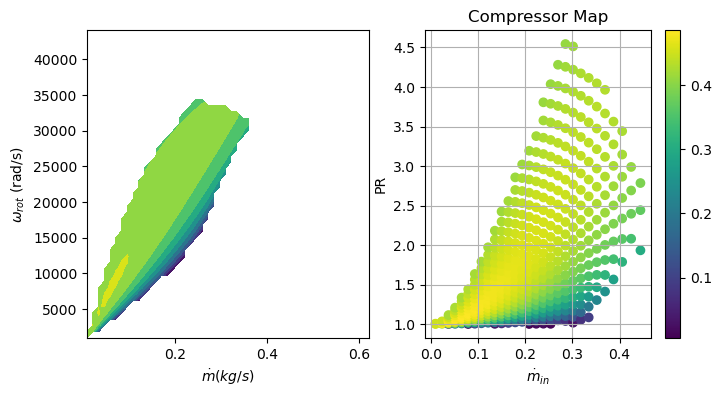

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(8)
fig.set_figheight(4)

xx, yy = X.T
ax[0].contourf(yy.reshape(50, 50), xx.reshape(50, 50), eta.reshape(50, 50))
ax[0].set_xlabel('$\dot{m} (kg/s)$')
ax[0].set_ylabel('$\omega_{rot}$ (rad/s)')

m = ax[1].scatter(m_in, pr, c=eta)
plt.colorbar(m)
ax[1].grid()
ax[1].set_title("Compressor Map")
ax[1].set_xlabel('$\dot{m}_{in}$')
ax[1].set_ylabel('PR')